In [10]:

import os
import yaml
import torch
import random
import logging
import statistics
import cv2
import numpy as np

import matplotlib.pyplot as plt
import torchvision.transforms as T
from accelerate import Accelerator
from yacs.config import CfgNode as CN
from main import get_config, init_accelerator, set_seed, FFPP
from src.models import Detector
logging.basicConfig(level="DEBUG")

num_frames = 20


class Obj:
    pass

In [11]:
# cfg_path = "logs/deepfake/deepfake/c23+resi+dbal+3e-3+4s20f+reg_vien(hf,s,pfa-s)+first6+SGD(0.9m)/new.yaml"
# CLIP loo-NT
# cfg_path = "logs/deepfake/deepfake/best/new.yaml"
# CLIP loo-DF
# cfg_path = "logs/deepfake/deepfake/c23+resi+dbal_v2+3e-3+4s20f+reg_vien(hf,s,pfa-s)+last6+SGD(0.9m)+DF/new.yaml"
# CLIP loo-FS
# cfg_path = "logs/deepfake/deepfake/c23+resi+dbal_v2+3e-3+4s20f+reg_vien(hf,s,pfa-s)+last6+SGD(0.9m)+FS/new.yaml"
# CLIP loo-F2F
# cfg_path = "logs/deepfake/deepfake/c23+resi+dbal_v2+3e-3+4s20 f+reg_vien(hf,s,pfa-s)+last6+SGD(0.9m)+F2F/new.yaml"
# CLIP tune-all
# cfg_path = "logs/test/JULY+tune_all/setting.yaml"
# FaRL tune-all
# cfg_path = "logs/test/misunderstood-glitter-939/setting.yaml"
# CLIP(smax) tune-all
# cfg_path = "logs/test/toasty-microwave-1006/setting.yaml"
# CLIP(coda) tune-all
# cfg_path = "logs/test/fancy-pyramid-1007/setting.yaml"
# CLIP(smax,frame_attn) tune-all
# cfg_path = "logs/test/different-jazz-1009/setting.yaml"
# CLIP(smax, temporal) tune-all
cfg_path = "logs/test/faithful-shape-1012/setting.yaml"

with open(cfg_path) as f:
    preset = CN(yaml.safe_load(f))

mc = Detector.get_default_config().merge_from_other_cfg(preset.model)
mc.op_mode.attn_record = True

accelerator = Accelerator(mixed_precision='no')

model = Detector(mc, num_frames, accelerator).to(accelerator.device)
encoder = model.encoder
model.load_state_dict(
    torch.load(
        os.path.join(os.path.split(cfg_path)[0], "best_weights.pt"),
        map_location="cpu"
    )
)


model.eval()
model = model.to("cuda")
mc

DEBUG:root:perform normal reference initialization.
DEBUG:root:perform normal reference initialization.
DEBUG:root:perform normal reference initialization.
DEBUG:root:perform normal reference initialization.
DEBUG:root:perform normal reference initialization.
DEBUG:root:perform normal reference initialization.
INFO:root:Adapter operates without pretrained weights!!!


CfgNode({'name': 'Detector', 'foundation': 'clip', 'architecture': 'ViT-B/16', 'decode_mode': CfgNode({'type': 'index', 'indices': [6, 7, 8, 9, 10, 11], 'stride': -1}), 'out_dim': [2], 'losses': ['auc_roc'], 'concat_ref': False, 'adapter': CfgNode({'type': 'normal', 'struct': CfgNode({'type': '768-x-768-nln', 'x': 256}), 'frozen': False, 'path': ''}), 'train_mode': CfgNode({'temporal': 'none', 'compression': 'none', 'patch_mask': CfgNode({'type': 'none', 'path': '', 'ratio': 1.0}), 'nerf_raw': -1.0}), 'op_mode': CfgNode({'temporal_position': True, 'attn_mode': 'temporal', 'attn_driver': ['smax'], 'attn_record': True, 'global_prediction': False, 'aug_query': False, 'ema_frame': -1.0}), 'dropout': 0.5, 'weight_decay': 0.01, 'optimizer': 'sgd'})

In [12]:

c = FFPP.get_default_config()
c.pack = 1
c.augmentation = "none"
c.random_speed = False
c.compressions = ["c23"]
# c.types = ["REAL", "FS","F2F","DF"]
# c.types = ["REAL", "NT","FS","F2F","DF"]
# c.types = ["FS"]

transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32),
    T.Normalize((0.48145466, 0.4578275, 0.40821073),
                (0.26862954, 0.26130258, 0.27577711)),
])

_transform = T.Compose([
    T.Resize(encoder.input_resolution, interpolation=T.InterpolationMode.BICUBIC),
    T.CenterCrop(encoder.input_resolution),
    T.ConvertImageDtype(torch.float32)
])

# x = FFPP(c.clone(), num_frames, 4, transform, accelerator, split="test")
# _x = FFPP(c.clone(), num_frames, 4, _transform, accelerator, split="test")
# c

In [13]:
import cv2
import numpy as np


def interpret(clip, mask, model, device, start_layer=0, num_layer=-1, logit_index=1, grad_only=False):
    torch.cuda.empty_cache()
    # duplicate image for further gradient operation to accord to different input sources
    num_patch = model.encoder.input_resolution // model.encoder.patch_size
    task_logits, features = model.predict(clip.unsqueeze(0).to(device), mask.unsqueeze(0).to(device))
    clip_logits = task_logits[0]
    probs = clip_logits.softmax(dim=-1).detach().cpu().numpy()
    print("Score:", clip_logits)
    print("Probs:", probs)
    one_hot = np.zeros((1, 1), dtype=np.float32)
    # diagonal matrix
    one_hot[0, 0] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    # only observe the fake logit score
    one_hot = torch.sum(one_hot.cuda() * clip_logits[:, logit_index])
    model.zero_grad()

    image_attn_blocks = list(dict(model.decoder.transformer.resblocks.named_children()).values())

    if start_layer == -1:
        # calculate index of last layer
        start_layer = len(image_attn_blocks) - 1

    if num_layer == -1:
        num_layer = len(image_attn_blocks)

    num_tokens = image_attn_blocks[0].attn.aff.shape[-2]
    num_queries = image_attn_blocks[0].attn.aff.shape[1]

    # create empty storage
    R = torch.zeros(num_queries, num_tokens, dtype=image_attn_blocks[0].attn.aff.dtype).to(device)
    # create saliency map for each input-output in interest
    R = R.unsqueeze(0)
    for i in range(start_layer, start_layer + num_layer):
        # calculate the gradient of attn_prob wrt the one_hot score(each pair of text and image)
        # the blk.attn.aff has shape of (12*n, 50, 50), n = batch_size, which is number of texts in this context.
        # 50 = 7*7 + 1, which 7*7 is the number of patches and 1 for the cls token.
        # The grad function will derive the gradient of the attention scores over the heads of the n image corresponding to the texts.
        # In this step, the purpose of duplicating the image according to the number of texts and creating the one_hot diagonal matrix
        # for the similarity score supported the purpose of splitting the affect of the image features corresponding to different texts.
        grad = torch.autograd.grad(
            one_hot,
            [image_attn_blocks[i].attn.aff],
            retain_graph=True
        )[0].detach()

        cam = image_attn_blocks[i].attn.aff.detach()

        # cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        # grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])

        # align the gradient with the cam score according to the elements positivity
        # (CODA could have negative cam values, but that doesn't mean it has low attention score,
        # the value it self should infact indicate the importance rather the sign.
        # If an element has both negative cam and grad values, this should indicate positive impact,
        # just like both having positive values.)
        grad = grad * (cam / torch.abs(cam))

        if (grad_only):
            cam = cam
        else:
            # due to coda, the value of the element indicates the importance, therefore abs is required.
            cam = torch.abs(cam)

            # regularize the overall representation, these causes bad visualizations.
            # norm
            # cam = (cam - cam.min())/(cam.max()-cam.min())
            # softmax
            # cam = cam.softmax(dim=-2)
            cam = grad * cam

        # reshape to restore (n,h,p^2+1,p^2+1)
        # cam = cam.reshape(1, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.permute((0, 3, 1, 2))

        # average over each heads.
        cam = cam.clamp(min=0).mean(dim=1)
        # the cam represents the multi-head averaged gradient weighted attention score for each frame corresponding to the texts.
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        R = R + cam / num_layer

    # video_relevance = R[:, 0]
    video_relevance = R
    video_relevance = video_relevance.view((num_queries, -1, num_patch, num_patch))
    return video_relevance, probs


def show_clip_relevance(clip, clip_relevance, q=0):
    clip_relevance = clip_relevance[q]
    # create heatmap from mask on image

    def show_cam_on_clip(clip, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255

        cam = heatmap + np.float32(clip)
        cam = cam / np.max(cam)
        return cam

    dim = int(clip_relevance.shape[-1])
    # process clip relevance map
    clip_relevance = clip_relevance.unsqueeze(1)
    clip_relevance = torch.nn.functional.interpolate(clip_relevance, size=224, mode='bilinear').cpu().numpy()
    clip_relevance = (clip_relevance - clip_relevance.min()) / (clip_relevance.max() - clip_relevance.min())
    # process clip frames
    clip = (clip - clip.min()) / (clip.max() - clip.min())
    clip = clip.cpu().numpy()

    # convert frame/cam sequence into a large frame
    clip_relevance = clip_relevance.transpose(2, 0, 3, 1).reshape(224, -1, 1)
    clip = clip.transpose(2, 0, 3, 1).reshape(224, -1, 3)
    # process
    cam = show_cam_on_clip(clip, clip_relevance)
    cam = np.uint8(255 * cam)
    cam = cv2.cvtColor(np.array(cam), cv2.COLOR_RGB2BGR)
    clip = np.uint8(255 * clip)
    return clip, cam

  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['REAL']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['REAL']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:240/57
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/634.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/634.avi, Completed!
DEBUG:root:Item/Video Index:241/57
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/634.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/real/c23/videos/634.avi, Completed!
DEBUG:root:Item/Video Index:242/57
DEBUG:root:Item DF/COMP:REAL/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/real/c23/videos/634.avi
DEBUG:root:Sample Offset: 8
DEBUG:

Score: tensor([[-1.4690, -4.7793]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.9647808  0.03521924]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['NT']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['NT']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:98/28
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/NT/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:99/28
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/NT/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:100/28
DEBUG:root:Item DF/COMP:NT/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/NT/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 8
DEBUG:

Score: tensor([[-4.6211, -1.9092]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.06227399 0.937726  ]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['FS']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['FS']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:95/27
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:96/27
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/FS/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:97/27
DEBUG:root:Item DF/COMP:FS/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/FS/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 8
DEBUG:r

Score: tensor([[-4.4952,  2.1893]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.00124858 0.9987514 ]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['F2F']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['F2F']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:127/28
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/F2F/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:128/28
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/F2F/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:129/28
DEBUG:root:Item DF/COMP:F2F/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/F2F/c23/videos/634_660.avi
DEBUG:root:Sample Offse

Score: tensor([[-4.9001, -0.9943]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.0197281 0.9802719]]


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['DF']
DEBUG:root:DF TYPES:['c23']


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:DF TYPES:['DF']
DEBUG:root:DF TYPES:['c23']
DEBUG:root:Item/Video Index:111/28
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/DF/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 0
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/DF/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:112/28
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/DF/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 4
DEBUG:root:Sample Stride: 0.20842105263157895
DEBUG:root:Video: ./datasets/ffpp/DF/c23/videos/634_660.avi, Completed!
DEBUG:root:Item/Video Index:113/28
DEBUG:root:Item DF/COMP:DF/c23
DEBUG:root:Video Speed Motion Factor: 1
DEBUG:root:Video Shift Factor: 0
DEBUG:root:Loading Video: ./datasets/ffpp/DF/c23/videos/634_660.avi
DEBUG:root:Sample Offset: 8
DEBU

Score: tensor([[-4.4864,  2.2073]], device='cuda:0', grad_fn=<DivBackward0>)
Probs: [[0.00123713 0.99876285]]


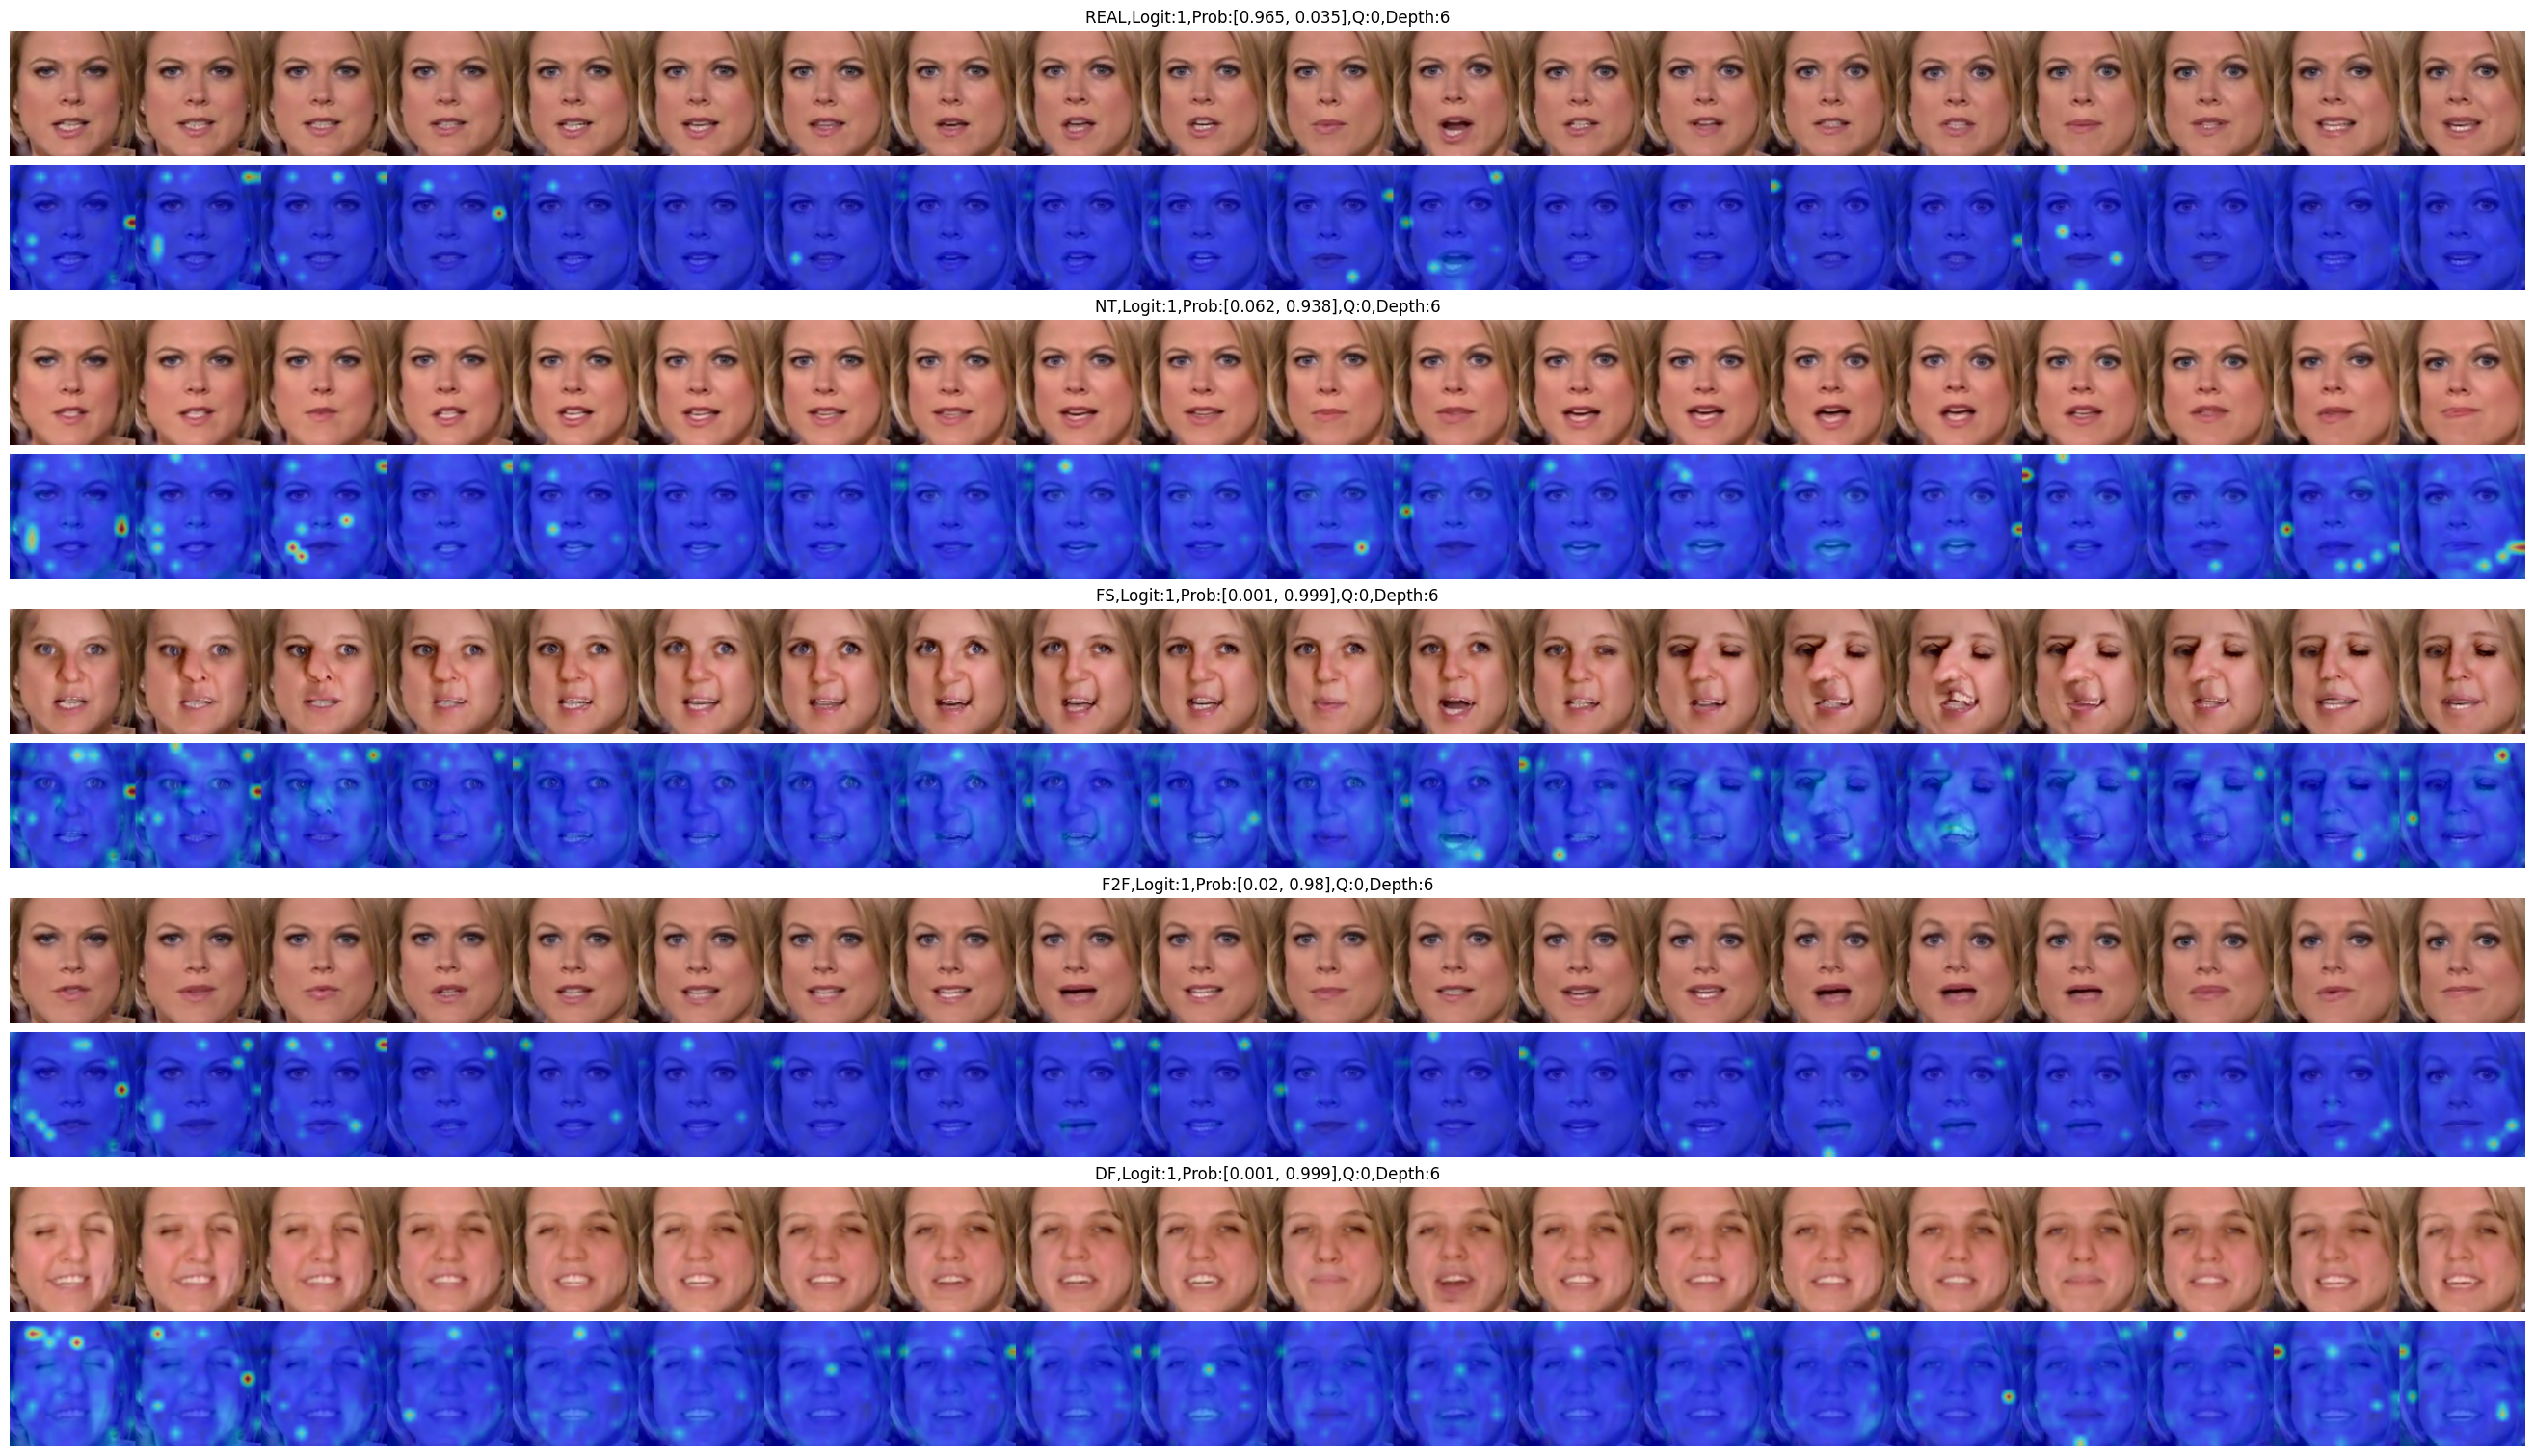

In [15]:
torch.cuda.empty_cache()

clip_heatmap_pairs = []
# Cs = list(range(model.decoder.num_classes))
Ds = list(range(1, len(model.layer_indices) + 1))
# Qs = list(range(model.decoder.class_embedding.shape[0]))
Cs = [1]
Ds = [6]
Qs = [0]
# Ds = [1]

# for dftype in ["NT","DF","FS"]:
# for dftype in ["REAL", "DF", "NT"]:
for dftype in ["REAL", "NT", "FS", "F2F", "DF"]:
    # for dftype in ["NT"]:
    c.types = [dftype]
    x = FFPP(c.clone(), num_frames, 4, transform, accelerator, split="test")
    _x = FFPP(c.clone(), num_frames, 4, _transform, accelerator, split="test")

    # select video index
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "691_732")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "851_552")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "691_732")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "089")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if "225" == d[2].split('_')[0])
    vid_idx = next(i for i, d in enumerate(x.video_list) if "634" in d[2])
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "507_418")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[0]=="DF" and d[2] == "855_801")
    # vid_idx = next(i for i, d in enumerate(x.video_list) if d[2] == "855")
    # vid_idx = 10
    # vid_idx = random.randrange(0, len(x))

    # sample video
    clips, label, masks, speed, meta, task_index = x[vid_idx]
    _clips = _x[vid_idx][0]
    clips = torch.stack(clips)
    masks = torch.stack(masks)

    # select single clip
    clip = clips[0]
    mask = masks[0]
    _clip = _clips[0]

    # generate
    for logit in Cs:
        for depth in Ds:
            # interpret prediction
            _clip_relevance, probs = interpret(
                clip, mask, model, "cuda", logit_index=logit,
                start_layer=0, num_layer=depth, grad_only=True
            )
            probs = [round(p, 3) for p in probs.flatten().tolist()]
            # heatmap for individual queries
            for q in Qs:
                flat_clip, flat_heatmap = show_clip_relevance(_clip, _clip_relevance, q)
                clip_heatmap_pairs.append(
                    (f"{dftype},Logit:{logit},Prob:{probs},Q:{q},Depth:{depth}", flat_clip, flat_heatmap))


# plot figures
num_figures = 2 * len(clip_heatmap_pairs)
plt.figure(figsize=(1.5 * num_frames, 1.5 * num_figures), layout="constrained")
for i, data in enumerate(clip_heatmap_pairs):
    title, flat_clip, flat_heatmap = data
    plt.subplot(num_figures, 1, i * 2 + 1)
    plt.title(title)
    plt.imshow(flat_clip)
    plt.gca().axis("off")
    plt.subplot(num_figures, 1, i * 2 + 2)
    plt.imshow(flat_heatmap)
    plt.gca().axis("off")
plt.show()